<a href="https://colab.research.google.com/github/Simoni2412/Wrinkles-and-Pores-Detection/blob/main/Test_Pores_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade --force-reinstall mediapipe==0.10.5

In [1]:
from tensorflow.keras.layers import Conv2D, Conv2D, UpSampling2D, BatchNormalization, ReLU, Multiply, Input, GlobalAveragePooling2D, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, MaxPooling2D, Dropout, Add, ZeroPadding2D
from tensorflow.keras.layers import Concatenate as Concat

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# prompt: Load the previous model from h5 file and test dataset has images and maska
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
from PIL import Image
from tensorflow.keras import layers

import tensorflow as tf
from tensorflow.keras.models import load_model

# Define your custom loss
# ---- Attention Module ----
def attention_block(x, g, inter_channels):
    theta_x = Conv2D(inter_channels, (1,1), padding="same")(x)
    phi_g = Conv2D(inter_channels, (1,1), padding="same")(g)
    add_xg = Add()([theta_x, phi_g])
    act_xg = Activation('relu')(add_xg)
    psi = Conv2D(1, (1,1), padding="same", activation="sigmoid")(act_xg)
    return Multiply()([x, psi])

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dsc = dice_loss(y_true, y_pred)
    return bce + dsc


def spatial_attention(x):
    avg_pool =  layers.Lambda(channel_avg)(x)
    max_pool = layers.Lambda(channel_max)(x)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    attention = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    return layers.Multiply()([x, attention])

#from tensorflow.keras.models import load_model
# model = tf.keras.models.load_model("/content/model_batch5 (1).h5")

def channel_avg(x):
    return tf.reduce_mean(x, axis=-1, keepdims=True)

def channel_max(x):
    return tf.reduce_max(x, axis=-1, keepdims=True)

custom_objects={
        'channel_avg': channel_avg,
        'channel_max': channel_max,
        'spatial_attention': spatial_attention,  # if applicable
        'dice_loss': dice_loss,
        'combined_loss': combined_loss,
        # add any other named functions
    }

model = load_model(
    '/content/model_pores_batch3.h5',
    custom_objects=custom_objects
)

model.summary()

In [24]:
import cv2
import numpy as np
import os
import mediapipe as mp

# Butterfly indices (as you have)
BUTTERFLY_ZONE_INDICES = [111, 117, 119, 120, 121, 128, 122, 6, 351, 357, 350, 349, 348, 347, 346, 345, 352, 376, 433, 416, 434, 432, 410, 423, 278, 344, 440, 275, 4, 45, 220, 115, 48, 203, 186, 186, 212, 214, 192, 123, 116]

mp_face_mesh = mp.solutions.face_mesh

def detect_landmarks(image):
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1) as face_mesh:
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks:
            return results.multi_face_landmarks[0]
    return None

def get_landmark_coords(image, landmarks, indexes):
    h, w = image.shape[:2]
    # Access the list of landmarks using the .landmark attribute
    landmark_list = landmarks.landmark
    return np.array([(int(landmark_list[i].x * w), int(landmark_list[i].y * h)) for i in indexes], np.int32)

def crop_to_butterfly_zone(image, landmarks, indices):
    h, w = image.shape[:2]
    butterfly_pts = get_landmark_coords(image, landmarks, indices)
    if butterfly_pts.size == 0:
        return None, None
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(mask, [butterfly_pts], 255)
    ys, xs = np.where(mask > 0)
    y_min, y_max = ys.min(), ys.max()
    x_min, x_max = xs.min(), xs.max()
    cropped_image = image[y_min:y_max, x_min:x_max]
    bbox = (x_min, y_min, x_max, y_max)
    return cropped_image, bbox

In [25]:
def load_images_and_bboxes(folder, img_size):
    images, bboxes = [], []
    for filename in sorted(os.listdir(folder)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder, filename)
            image = cv2.imread(img_path)
            if image is None:
                print(f"Could not read {img_path}")
                continue
            landmarks = detect_landmarks(image)
            if landmarks is None:
                print(f"No face detected in {filename}")
                continue
            cropped_img, bbox = crop_to_butterfly_zone(image, landmarks, BUTTERFLY_ZONE_INDICES)
            if cropped_img is None:
                print(f"Could not crop butterfly region in {filename}")
                continue
            resized_img = cv2.resize(cropped_img, img_size)
            normalized_img = resized_img.astype(np.float32) / 255.0
            images.append(normalized_img)
            bboxes.append(bbox)
    return np.array(images), bboxes

def load_masks_from_folder(folder, img_size, bbox_list):
    masks = []
    for filename, bbox in zip(sorted(os.listdir(folder)), bbox_list):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            mask_path = os.path.join(folder, filename)
            mask = cv2.imread(mask_path, 0)  # Grayscale
            if bbox is None:
                continue
            x_min, y_min, x_max, y_max = bbox
            cropped_mask = mask[y_min:y_max, x_min:x_max]
            resized_mask = cv2.resize(cropped_mask, img_size, interpolation=cv2.INTER_NEAREST)
            masks.append(resized_mask)
    return np.array(masks)

In [26]:
IMG_SIZE = (256, 256)
image_folder = '/content/drive/MyDrive/Dataset /Originals'
mask_folder = '/content/drive/MyDrive/Dataset /Pores_Masks'

test_images, bboxes = load_images_and_bboxes(image_folder, IMG_SIZE)
test_masks = load_masks_from_folder(mask_folder, IMG_SIZE, bboxes)
test_masks = np.expand_dims(test_masks, axis=-1)  # Add channel if needed

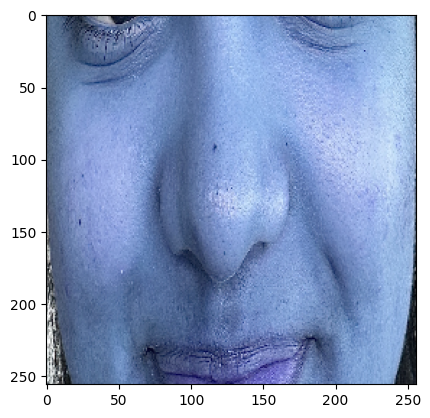

In [109]:
import matplotlib.pyplot as plt
plt.imshow(test_images[44])

2/2 ━━━━━━━━━━━━━━━━━━━━ 43s 15s/step
Mean IoU: nan


<ipython-input-110-1477672734>:14: RuntimeWarning: invalid value encountered in scalar divide
  iou = np.sum(intersection) / np.sum(union)


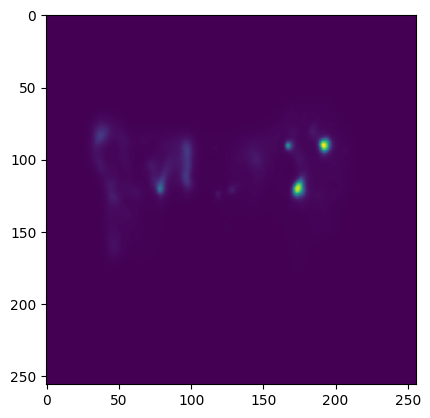

In [110]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
# cv2_imshow((test_images[0]*255).astype(np.uint8))
# Predict masks
predicted_masks = model.predict(test_images)
plt.imshow(predicted_masks[44])
# Optional: Binarize predictions if needed
predicted_masks = (predicted_masks > 0.2).astype(np.uint8)

# Example: Calculate IoU (Intersection over Union) for evaluation
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

ious = [iou_score(true, pred) for true, pred in zip(test_masks, predicted_masks)]
print(f"Mean IoU: {np.mean(ious):.4f}")

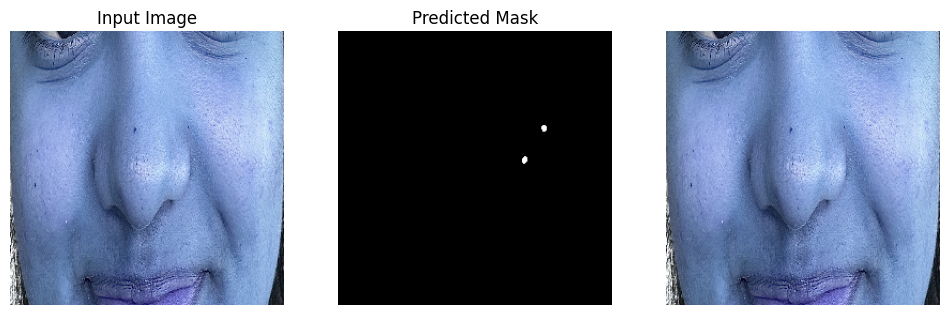

In [108]:
import matplotlib.pyplot as plt

idx =  44# Change to see other images
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title('Input Image')
#test_images[idx] = test_images.astype(np.float32) / 255.0
plt.imshow(test_images[idx])
plt.axis('off')
plt.subplot(1,3,2)
plt.title('Predicted Mask')
plt.imshow(predicted_masks[idx].squeeze(), cmap='gray')
plt.axis('off')
plt.subplot(1,3,3)
#plt.title(f'Score: {wrinkle_scores[idx]:.4f}\nAge: {ages[idx]:.1f}')
plt.imshow(test_images[idx])
plt.axis('off')
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def overlay_mask_on_image(image, mask, alpha=0.5, mask_color=(255, 0, 0)):
    """
    Overlays a predicted mask on an image.

    Parameters:
    - image: original image, shape (H, W, 3), float32 [0–1] or uint8 [0–255]
    - mask: predicted mask, shape (H, W) or (H, W, 1), float32 [0–1] or uint8
    - alpha: transparency factor for mask overlay
    - mask_color: RGB color for the overlay (default is red)

    Returns:
    - overlayed image (uint8)
    """
    # Convert image to uint8
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # Ensure mask is 2D
    if mask.ndim == 3:
        mask = mask[:, :, 0]

    # Resize mask to match image if needed
    if mask.shape != image.shape[:2]:
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

    # Normalize mask to [0, 255] and convert to uint8
    if mask.max() <= 1.0:
        mask = (mask * 255).astype(np.uint8)
    else:
        mask = mask.astype(np.uint8)

    # Create a color version of the mask
    color_mask = np.zeros_like(image)
    color_mask[:, :] = mask_color  # e.g., red mask
    color_mask = cv2.bitwise_and(color_mask, color_mask, mask=mask)

    # Overlay
    overlayed = cv2.addWeighted(image, 1.0, color_mask, alpha, 0)

    return overlayed


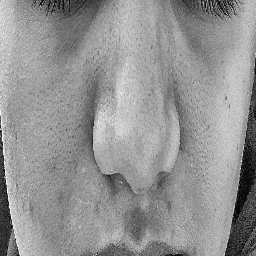

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


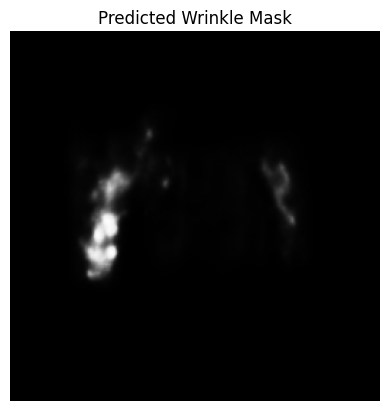

In [95]:
def predict_on_unlabeled(model, image):
    landmark = detect_landmarks(image)
    cropped_img, bbox = crop_to_butterfly_zone(image, landmark, BUTTERFLY_ZONE_INDICES)
    img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    normalized = enhanced.astype(np.float32) / 255.0

    # Convert to 3 channels
    image = np.stack([normalized]*3, axis=-1)

    #img = np.expand_dims(img, axis=0)

    # Ensure IMG_SIZE is a tuple of integers
    image = cv2.resize(image, IMG_SIZE)
    img = np.expand_dims(image, axis=0)

    cv2_imshow((image*255).astype(np.uint8))
    pred = model.predict(img)
    # If model output is (1, 256, 256, 1), squeeze to (256, 256)
    if pred.shape[-1] == 1:
        pred = pred[0, ..., 0]
    else:
        pred = pred[0]
    return pred, cropped_img, bbox

# Example usage:
unlabeled_img_path = '/content/drive/MyDrive/Dataset /Originals/IMG_0057.jpg'
img = cv2.imread(unlabeled_img_path)
pred_mask, cropped_img, bbox = predict_on_unlabeled(model, img)
plt.imshow(pred_mask , cmap='gray')
plt.title('Predicted Wrinkle Mask')
plt.axis('off')
plt.show()

In [102]:
def overlay_mask_on_image(image, mask, bbox=None, alpha=0.5, mask_color=(255, 0, 255)):
    """
    Overlays a binary mask on the image. If bbox is given, places the mask in the correct region.
    """
    # Convert image to uint8 if needed
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # Ensure mask is 2D
    if mask.ndim == 3:
        mask = mask[:, :, 0]

    # Binarize mask (adjust threshold as needed)
    mask_bin = (mask > 0.1).astype(np.uint8) * 255

    # If overlaying on a cropped region, just overlay
    if bbox is None:
        mask_resized = cv2.resize(mask_bin, (image.shape[1], image.shape[0]))
        color_mask = np.zeros_like(image)
        color_mask[mask_resized > 0] = mask_color
        overlayed = cv2.addWeighted(image, 1.0, color_mask, alpha, 0)
        return overlayed

    # If overlaying on the original image, place the mask in the correct location
    x_min, y_min, x_max, y_max = bbox
    mask_resized = cv2.resize(mask_bin, (x_max - x_min, y_max - y_min))
    color_mask = np.zeros_like(image)
    color_mask[y_min:y_max, x_min:x_max][mask_resized > 0] = mask_color
    overlayed = cv2.addWeighted(image, 1.0, color_mask, alpha, 0)
    return overlayed


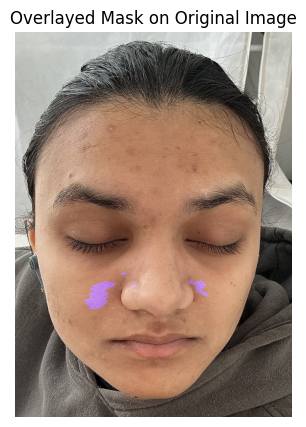

In [103]:
# original_img: the original (uncropped) image
# pred_mask: the predicted mask (should be resized to match the overlay region on the original image)

# If you want to overlay on the original image, you need to place the mask back in the original image coordinates:
# (Assume bbox = (x_min, y_min, x_max, y_max) from your crop_to_butterfly_zone)
overlay_on_original = img.copy()
overlayed_crop = overlay_mask_on_image(cropped_img, pred_mask, alpha=0.5, mask_color=(255, 0, 0))
x_min, y_min, x_max, y_max = bbox
overlay_on_original[y_min:y_max, x_min:x_max] = overlayed_crop

# Show the overlay
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.imshow(cv2.cvtColor(overlay_on_original, cv2.COLOR_BGR2RGB))
plt.title("Overlayed Mask on Original Image")
plt.axis('off')
plt.show()